## The problem

Here I address the following question.  Suppose that we would like to pick out a desirable subset from a collection of items based on a quantitative value $x$ (smaller the $x$, more desirable the item), and we can measure or compute this value to within certain accuracy $\delta$.  If we select the top $f$ fraction of the items based on the computed values $\bar{x}$, what is the probability that the true value of any given selection is smaller than a cutoff value $x_c$?   

## The math

I will start with some assumptions.  First, the true values of the items follow certain probabilty distribution $p_t(x)$.  For simplicity, I take this to be a normal distribution with a mean of $x_0$ and a standard deviation of $\sigma$.

$p_t(x) = (\sqrt{2\pi} \sigma)^{-1} \exp\left(-\frac{(x - x_0)^2}{2\sigma^2}\right)$

Second, the measured or computed value deviates from the true value by an error that can be described by a probability distribution $p_c(\bar{x}|x) = p_c( \bar{x} - x )$.  For simplicity, I take this to be also a normal distribution

$p_c( \bar{x} | x ) = (\sqrt{2\pi}\delta)^{-1} \exp\left( - \frac{(\bar{x} - x)^2}{2\delta^2}\right)$

The conditional probability that we are after is then

$p(x\leq x_c|\bar{x} \leq \bar{x}_c)$

where $\bar{x}_c$ is the cutoff value for the top $f$ fraction of the lowest measured values, i.e.,

$p(\bar{x}\leq \bar{x}_c) = f$

We can compute the sought probability by

$p(x\leq x_c|\bar{x}\leq \bar{x}_c) = \int_{-\infty}^{x_c} p(x|\bar{x}\leq \bar{x}_c) dx
 = \int_{-\infty}^{x_c} \frac{p_t(x) p(\bar{x} \leq \bar{x}_c | x)}{p(\bar{x} \leq \bar{x}_c)} dx$

The conditional probability $p(\bar{x}\leq\bar{x}_c|x)$ is given by

$p(\bar{x}\leq\bar{x}_c|x) = \int_{-\infty}^{\bar{x}_c} p(\bar{x}|x)d\bar{x} = \frac{1}{2}\left(1 + \mathrm{erf}\left(\frac{\bar{x}_c - x}{\sqrt{2}\delta}\right)\right)$

Thus

$p(x\leq x_c|\bar{x}\leq \bar{x}_c) = (2f)^{-1} \int_{-\infty}^{x_c} p_t(x) \left(1 + \mathrm{erf}\left(\frac{\bar{x}_c - x}{\sqrt{2}\delta}\right)\right) dx$

To determine $\bar{x}_c$ from $f$, we note that

$f = p(\bar{x} \leq \bar{x}_c) = \int_{-\infty}^{\bar{x}_c} p(\bar{x}) d\bar{x} = \frac{1}{2}\left(1 + \mathrm{erf}\left(\frac{\bar{x}_c - x_0}{\sqrt{2(\sigma^2 + \delta^2)}}\right)\right)$

where $p(\bar{x})$ is the marginal distribution of the measured values $\bar{x}$:

$p(\bar{x}) = \int p_t(x) p_c(\bar{x}|x) dx = \left(\sqrt{2\pi(\sigma^2 + \delta^2}\right)^{-1} \exp\left( - \frac{(\bar{x} - x_0)^2}{2(\sigma^2 + \delta^2)} \right)$

### Discrete selections

If we are selecting the top $n$ itesm out a total of $N$ items based on the predicted values, we would like to know what is the probability that ONE out of the $n$ selections have the desired value $x \leq x_c$.  For each of the selected item the probability is $p_1 = p(x\leq x_c|\bar{x}\leq \bar{x}_c)$, where $p(\bar{x}\leq\bar{x}_c) = f \equiv n/N$.  Thus the probability that one of the items has $x \leq x_c$ is 

$p_n = 1 - (1 - p_1)^n$

## The code

In [51]:
import numpy as np
from scipy.optimize import fsolve
from scipy.special import erf
from scipy.integrate import quad

sqrt2 = np.sqrt(2.)
sqrt2pi = np.sqrt( 2*np.pi)

In [2]:
def gaussian( y, m, s):
    t = (y - m)/s
    return 1/(sqrt2pi*s)*np.exp(-0.5*t*t)

In [68]:
def pxc( xc, m, s):
    '''
    Compute p(x <= xc) for a normal distribution with mean m and standard deviation s.
    '''
    return 0.5*(1 + erf( (xc - m)/(sqrt2*s)))

In [96]:
def test_pxc( m=0.5, s=1.3):
    success = True
    for xc in np.arange( m - 3*s, m + 3*s, 0.1):
        p, err = quad( lambda x: gaussian(x, m, s), -np.inf, xc)
        pp = pxc( xc, m, s)
        success = success and (np.abs(pp - p) < err)
        
    return success

test_pxc()

True

In [90]:
def solve_xc( f, x0, s):
    '''
    Solve the equation of xc
    
    p(x <= xc) = f
    
    where p is a normal distribution with mean x0 and standard deviation s.
    '''
    xc = fsolve( lambda x: 0.5*(1 + erf( (x - x0)/(sqrt2*s))) - f, 0.)
    return xc[0]

Unit test: $p(x\leq x_c) \equiv f$

In [91]:
def test_solve_xc( m=0.1, s=1.5, tol=1e-12):
    df = []
    for f0 in np.arange( 0, 1, 0.2):
        f, err = quad( lambda x: gaussian( x, m, s), -np.inf, solve_xc(f0, x0=m, s=s))
        df.append( np.abs(f - f0))
        print f, f0
    maxdf = np.max( df)
    return maxdf < tol, maxdf

test_solve_xc()

9.03263728251e-18 0.0
0.2 0.2
0.4 0.4
0.6 0.6000000000000001
0.8 0.8


(True, 5.551115123125783e-16)

In [92]:
def pxcinf( xc, f, x0, s, d):
    '''
    Compute p(x<=xc | xb <= xbc), where p(xb <= xbc) = f.
    '''
    sd = np.sqrt(s*s + d*d)
    xbc = solve_xc( f, x0, sd)
    y, err = quad( lambda x: gaussian(x, x0, s)*(1 + erf((xbc - x)/(sqrt2*d))), -np.inf, xc)
    return y/(2*f)

Sanity check: if we have perfectly accurate results, any item in the top $f$ fraction based on the computed results should satisfy $x \leq x_c$ where $p_t(x\leq x_c) = f$.

In [112]:
def test_pxcinf_perfect_accuracy( x0=0.3, s=1.2, d=1e-10, tol=1e-12):
    dp = []
    for f0 in np.arange( 1e-3, 1, 0.1):
        p = pxcinf( solve_xc( f0, x0, s), f0, x0, s, d)
        print p
        dp.append( np.abs(p - 1.))
    maxdp = np.max( dp)
    return maxdp < tol, maxdp

test_pxcinf_perfect_accuracy()

1.000000000000023
1.0000000000000115
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0
1.0
1.0
1.0000000000000127
0.9999999999999962


(True, 2.3092638912203256e-14)

Sanity check: if the measured values are infinitely inaccurate ($\delta = \infty$), the probability that any selected item will have $x \leq x_c$ is simply the uninformed probability $p_t( x\leq x_c)$.

In [94]:
def test_pxcinf_uninformative( x0=0.3, s=1.2, d=1e7, tol=1e-7):
    dp = []
    for f in np.arange( 1e-3, 1, 0.1):
        xc = solve_xc( f, x0, s)
        p = pxcinf( xc, f, x0, s, d)
        print p, pxc( xc, x0, s)
        dp.append( np.abs( p - pxc( xc, x0, s)))
    maxdp = np.max( dp)
    return maxdp < tol, maxdp

test_pxcinf_uninformative()

0.0010000013594661718 0.0010000000000000009
0.10100003712886299 0.1010000000000012
0.20100004707440924 0.20100000000000012
0.3010000483405012 0.30100000000000016
0.4010000447248005 0.401
0.5010000381207048 0.501
0.601000029763167 0.6010000000000001
0.7010000206319152 0.7010000000000001
0.8010000116714892 0.8009999999999999
0.9010000040422378 0.9009999999999965


(True, 4.834050104651766e-08)

### Numerical simulations

In [133]:
def simulate_pfound( N, n, xc, x0, s, d, trials = 1000):
    '''
    Compute the probability that of $n$ items out a total of $N$ with the lowest predicted x values, one of them 
    has a true x value x <= xc, given the accuracy d.
    
    The true values have a normal distribution with mean x0 and standard deviation s.
    '''
    success = 0
    for t in xrange( trials):
        xs = np.random.normal( x0, s, N)
        xbs = np.array( [ np.random.normal( xs[i], d) for i in xrange( N) ])  # predicted values
        js = range( N)
        js.sort( key=lambda i: xbs[i])
        success += np.any( xs[js[:n]] < xc)
    return success/float(trials)

## The examples

In [170]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update( {'font.size': 16})

We want to pick molecules based on their computed binding free energies. Suppose that among any random set of candidate molecules, only one out one hundred ($f_c = 0.01$) molecules improves the binding free energy by $\Delta\Delta G \leq -1.36$ (kcal/mol), and the molecules have relative binding free energies centered around $\langle \Delta\Delta G \rangle = 0$.  The standard deviation in the $\Delta\Delta G$, assuming normal distribution, is then

In [125]:
g0 = 0.
gc = -1.36
fc = 0.01
sg = fsolve( lambda s: pxc(gc, g0, s) - fc, 1.)[0]
print 'std(ddG) = %.3f' % sg

std(ddG) = 0.585


If we computationally screen $N=100$ molecules, and pick the top $n=10$ ($f=n/N=0.1$) molecules based on computed $\Delta\Delta G_{\mathrm{RBFE}}$, the probability that any of the selected molecule will have $\Delta\Delta G \leq -1.36$ is 

In [120]:
def pddGgood( delta, f=0.1, gc=gc, g0=g0, sg=sg):
    '''
    Compute the probability that any of the computationally selected molecule in the top f fraction has a good 
    ddG < gc, if the computational accuracy is delta.   
    '''
    return pxcinf( gc, f, g0, sg, delta)

We are interested in the probability that one of the $n$ selected molecules has $\Delta\Delta G\leq\Delta\Delta G_c$. Let's compute these at different accuracy levels:

In [192]:
myaccuracies = np.array( [0.2, 0.5, 0.75, 1., 1.5, 3.])
myresults = dict()

In [193]:
def pfoundit_vs_accuracy( ds, n=10, f=0.1, gc=gc, g0=g0, sg=sg):
    ps = np.array( [ pddGgood( d, f, gc, g0, sg) for d in ds ])
    return 1 - np.power((1-ps), n)

myresults['pfound'] = dict( ds=myaccuracies,
                            ps=pfoundit_vs_accuracy( myaccuracies))

In [194]:
myresults['pfound']

{'ds': array([0.2 , 0.5 , 0.75, 1.  , 1.5 , 3.  ]),
 'ps': array([0.65113093, 0.59309377, 0.49972386, 0.41885856, 0.31333328,
        0.19638625])}

In [198]:
def simulate_pfound_vs_accuracy( ds, N=100, n=10, xc=gc, x0=g0, s=sg, trials=2000, repeats=5):
    ps = []
    for d in ds:
        p = np.zeros( repeats)
        for r in xrange(repeats):
            p[r] = simulate_pfound( N, n, xc, x0, s, d, trials)
        ps.append( (np.mean(p), np.std(p)))
    return np.array(ps)

myresults['pfoundsim'] = dict( ds = myaccuracies,
                            ps = simulate_pfound_vs_accuracy( myaccuracies, trials=2000, repeats=10))   

In [199]:
myresults['pfoundsim']

{'ds': array([0.2 , 0.5 , 0.75, 1.  , 1.5 , 3.  ]),
 'ps': array([[0.6273    , 0.01340187],
        [0.57905   , 0.00678767],
        [0.4857    , 0.00815843],
        [0.4124    , 0.00645291],
        [0.3073    , 0.01345028],
        [0.18845   , 0.00686094]])}

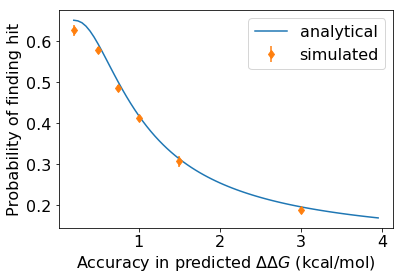

In [200]:
def plot_pfound_vs_accuracy( pfoundsim, n=10, f=0.1, gc=gc, g0=g0, sg=sg):
    ds = np.arange( 0.2, 4, 0.05)
    ps = pfoundit_vs_accuracy( ds, n, f, gc, g0, sg)
    fig, ax = plt.subplots()
    ax.plot( ds, ps, label='analytical')
    dsp, psp = pfoundsim['ds'], pfoundsim['ps']
    ax.errorbar( dsp, psp[:,0], yerr=psp[:,1], fmt='d', label='simulated')
    ax.set_xlabel('Accuracy in predicted $\Delta\Delta G$ (kcal/mol)')
    ax.set_ylabel('Probability of finding hit')
    ax.legend( loc='best')
    return fig

_ = plot_pfound_vs_accuracy( myresults['pfoundsim'])
    

Let's also compute the following conditional probability: if there is indeed at least one molecule out the $N$ molecule with $\Delta\Delta G \leq \Delta\Delta G_c$, what is the probability that it is among the $n$ top selections based on the computed $\Delta\Delta G$ values?

$p(\mathrm{found\ in\ }n|\min(x) \leq x_c) = p(\min(x) \leq x_c | \mathrm{found\ in\ }n) p(\mathrm{found\ in\ }n)/p(\min(x) \leq x_c) = p(\mathrm{found\ in\ }n)/p(\min(x) \leq x_c)$

where we have used the obvious fact $p(\min(x) \leq x_c | \mathrm{found\ in\ }n) = 1$: if we found an item with $x<x_c$ in the top $n$, then surely $\min(x)\leq x_c$.

$p(\min(x) \leq x_c) = 1 - (1 - p(x\leq x_c))^N$

In [206]:
zip(myresults['pfoundsim']['ds'], myresults['pfoundsim']['ps']/(1 - np.power((1 - pxc(gc, g0, sg)), 100)))

[(0.2, array([0.98948265, 0.02113967])),
 (0.5, array([0.91337467, 0.01070665])),
 (0.75, array([0.76612741, 0.01286884])),
 (1.0, array([0.65050637, 0.0101786 ])),
 (1.5, array([0.48472504, 0.02121603])),
 (3.0, array([0.29725491, 0.01082222]))]